# Word Vectors

En este trabajo, utilizaremos **embeddings** para resolver un problema de clasificación de texto. Los embeddings, representaciones distribuidas y vectoriales de elementos, son un concepto muy común en el mundo del deep learning. Los **word vectors** que hemos visto en clase son una representación en forma de embedding de las palabras.

Para realizar este trabajo y sacarle el máximo partido, se recomienda ver los siguientes vídeos de clase:

*   Clasificación de texto con Word Vectors.
*   Análisis de overfitting con un modelo bag of words.
*   Clasificación de texto con RNN

Vamos a utilizar el dataset **"Reuters newswire topics classification"**, disponible desde Keras de manera similar al dataset de IMDB ([ver documentación](https://keras.io/datasets/#reuters-newswire-topics-classification)).

---

Se pide:

Entrenar un modelo **utilizando embeddings** que consiga un **65% de accuracy en test (55% si usamos RNNs)**, mostrando el entrenamiento y el resultado final.
 
Tenemos varias opciones para entrenar modelos con embeddings. El alumno puede explorar más de una pero es suficiente con conseguir un modelo que alcance la accuracy requerida:

*   Utilizar una **media de embeddings** al estilo de lo visto en el vídeo *Clasificación de texto con Word Vectors*
*   Utilizar una **CNN** sobre una secuencia de word vectors. Aquí necesitamos cambiar un poco la idea de convolución para actuar sobre sequencias de vectores. Keras incluye una [Convolución en 1D](https://keras.io/layers/convolutional/#conv1d) que puede ser utilizada en este caso, con un ejemplo de uso en la documentación. Una forma de hacer funcionar este esquema sería utilizar la convolución en 1D + max pooling.
*  Utilizar una **RNN** sobre una secuencia de word vectors, al estilo de lo visto en el vídeo *Clasificación de texto con RNN*. Para este problema es un poco complicado conseguir un buen modelo con RNNs, y además es más difícil experimentar ya que las redes recurrentes son modelos lentos de entrenar. Por eso, es suficiente con alcanzar un 55% de accuracy si optamos por utilizar un modelo de este estilo. Un buen consejo es emplear una red recurrente bidireccional como se ve en el vídeo *Clasificación de texto con RNN*.



---

Dos hiperparámetros importantes a elegir en el modelo son la **longitud de las secuencias de texto** y el **tamaño del vocabulario** para los embeddings. Podéis experimentar con ambos, o utilizar los mismos que se usan en los vídeos. Nótese que, al cortar todas las secuencias para que tengan el mismo tamaño, podríamos estar perdiendo mucho texto si elegimos un tamaño de secuencia demasiado pequeño. Igualmente, si las hacemos muy largas necesitaremos más tiempo para entrenar nuestros modelos. Una buena idea consiste en explorar los datos para ver cómo suelen ser de largos los textos y encontrar un buen trade-off para el tamaño de al secuencia.



---

Los embeddings que hemos visto en los vídeos se entrenan junto al modelo.  Una técnica frecuente es inicializar estos embeddings con word-vectors pre-entrenados en un gran corpus de texto, como hemos visto en clase. Esto puede ayudar ya que nuestro modelo empieza con unos embeddings que ya encapsulan significado. Si bien no es necesario para esta práctica, podéis ver cómo usar esta técnica [en el siguiente tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).




# Importamos Librerias para todo el trabajo

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import keras
import keras.datasets

Using TensorFlow backend.


# Bajamos y armamos el DataSet

In [71]:
## Bajamos el IMDB dataset y armamos el dataset

NUM_WORDS  = 5000 # Cantidad de palabras a utilizar
INDEX_FROM = 3    # Offset para las primeras palabras


if False:
    (x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data( path="imdb.npz",
                                                                          num_words=NUM_WORDS,
                                                                          skip_top=0,
                                                                          maxlen=None,
                                                                          seed=113,
                                                                          start_char=1,
                                                                          oov_char=2,
                                                                          index_from=INDEX_FROM)
    word_to_id = keras.datasets.imdb.get_word_index()                                
else:
    (x_train, y_train), (x_test, y_test) = keras.datasets.reuters.load_data(path="reuters.npz",
                                                                            num_words=NUM_WORDS,
                                                                            skip_top=0,
                                                                            test_split=0.2,
                                                                            maxlen=None,
                                                                            seed=113,
                                                                            start_char=1,  # Son los "<START>"
                                                                            oov_char=2,    # Son los "<UNK>"
                                                                            index_from=INDEX_FROM)
    word_to_id = keras.datasets.reuters.get_word_index()


# Construyo los dicts para pasar de id a word y viceversa
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}

word_to_id["<PAD>"]   = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"]   = 2

id_to_word = {value:key for key,value in word_to_id.items()}


# Armo los datasets, aún las secuencias no están recortadas no paddeadas
ds_trn = {'input': x_train,
          'target': y_train}

ds_tst = {'input':  x_test,
          'target': y_test}


NUM_CLASSES   = y_train.max() + 1

# Visualizamos el dataset

 - Datos TRAIN:   input_shape=(8982,) target_shape=(8982,)
 - Datos TEST :   input_shape=(2246,) target_shape=(2246,)
 - Cantidad de clases: 46
 - Secuencia: <START> <UNK> <UNK> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
 - Clase asignada: 3


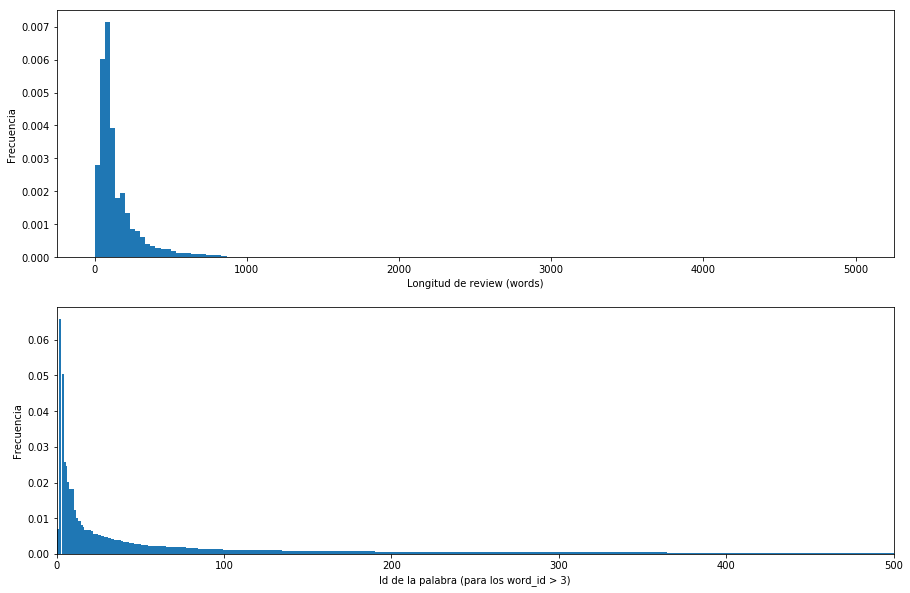

In [72]:
# Mostramos el contenido
print(' - Datos TRAIN:   input_shape={} target_shape={}'.format(ds_trn['input'].shape, ds_trn['target'].shape))
print(' - Datos TEST :   input_shape={} target_shape={}'.format(ds_tst['input'].shape, ds_tst['target'].shape))
print(" - Cantidad de clases: {}".format(NUM_CLASSES))

# Mostramos una secuencia
print(' - Secuencia:', ' '.join( [id_to_word[i] for i in ds_trn['input'][0]]) )
print(' - Clase asignada:', ds_trn['target'][0])


# Gráficas
len_v = []
freq_c = Counter()
for ds in [ds_trn['input'], ds_tst['input']]:
    for v in ds:
        len_v.append( len(v) )
        w_id_v, count_v = np.unique(v, return_counts=True)
        for w_id, count in zip(w_id_v, count_v):
            freq_c[w_id] += count
            
len_v  = np.array(len_v)
freq_a = np.array( sorted( freq_c.items() ), dtype=np.float)
freq_a[:,1] = freq_a[:,1]/freq_a[:,1].sum()



f,axes = plt.subplots(2,1, figsize=(15,10))

ax = axes[0]
ax.hist(len_v, bins=150, normed=True, range=(0,NUM_WORDS))
ax.set_xlabel('Longitud de review (words)')
ax.set_ylabel('Frecuencia')


ax = axes[1]
ax.bar(freq_a[:,0], freq_a[:,1], 1.0)
ax.set_xlabel('Id de la palabra (para los word_id > 3)')
ax.set_ylabel('Frecuencia')
ax.set_xlim((0,500))

plt.show()


## Comentarios:
- Se cargó el dataset de Reuters con las 1000 palabras de mayor frecuencia
- El dataset de train cuenta con 8982 reviews y el de dataset test con 2246 (repartición 80% y 20%).
- De la gráfica de la distribución de longitud de Temas de Noticias, podemos ver que al elegir una longitud de secuencia mayores que 300 palabras, conservamos la mayoría de los comentarios completos. Para 300 palabras conservamos el 88.8% de las secuencuas completas. Para 400 conservamos el 93% de las secuencias completas. Al entrenar el modelo se eligirán estos valores como longitud de secuencias.
- La grafica de frecuencia de palabras nos muestra que la elección de las 5000 palabras más relevantes deja una cola en la distribución de frecuencias de palabras muy pequeña (freq < 1.34237525e-05).
- Se agregaron 3 ids especiales **< PAD >** para completar las secuencias cortas, **< UNK >** para palabras desconocidas de menor frecuenca que no fueron cargadas del dataset, y **< START >** para marcar el inicio de una nueva review.

# Recortamos y paddeamos las reviews del dataset

En esta etapa recorto los Topics del dataset para que el modelo tenga de entrada una dimension constante. También al target lo transformo en una one-hot-verctor de dimensión 46 para poder entrenar el clasificador.

In [73]:
MAX_SEQ_LEN = 200

for ds in [ds_trn, ds_tst]:
    ds['input_pad'] = keras.preprocessing.sequence.pad_sequences(ds['input'],
                                                             maxlen=MAX_SEQ_LEN,
                                                             padding='post',
                                                             value=0)
    
    ds['target_oh'] = keras.utils.to_categorical(ds['target'])
    
print(' - Secuencia con pad:', ' '.join( [id_to_word[i] for i in ds_trn['input_pad'][0]]) )
print(' - Target_shape:',ds_trn['target_oh'].shape )

 - Secuencia con pad: <START> <UNK> <UNK> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

# Construyo y entrenmo un modelo convolucional

In [74]:
def build_model(input_shape=(MAX_SEQ_LEN,), n_output=NUM_CLASSES, n_words=NUM_WORDS, embedding_size=20, verbose=True):
    
    # Agrego una layer de entrada.
    sequence_input = keras.layers.Input(shape=input_shape, dtype='int32')
    
    # Agrego el embedding
    embedded_sequences = keras.layers.Embedding(input_dim=n_words,
                                                output_dim=embedding_size,
                                                input_length=input_shape[0],
                                                
                                                embeddings_initializer='uniform',
                                                embeddings_regularizer=None,
                                                activity_regularizer=None,
                                                embeddings_constraint=None,
                                                mask_zero=False)(sequence_input)
    
    # Construyo el modelo a partir del embeding resultante.
    # Propongo un modelo convolucional 1D con capas de pooling
    x = keras.layers.Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = keras.layers.MaxPooling1D(5)(x)
    
    x = keras.layers.Conv1D(128, 5, activation='relu')(x)
    x = keras.layers.MaxPooling1D(5)(x)
    
#     x = keras.layers.Conv1D(128, 5, activation='relu')(x)
#     x = keras.layers.MaxPooling1D(35)(x)
    
    # Agrego DropOut
    x = keras.layers.Dropout(0.5)(x)
    
    # Ahora la capa Dense, y armo la salida con una capa softmax
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    
    preds = keras.layers.Dense(n_output, activation='softmax')(x)

    
    model = keras.models.Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    
    if verbose:
        model.summary()
    
    return model

# Creo el modelo convolucional 1D
model_conv1d = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 20)           100000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          12928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 128)            0         
__________

In [ ]:
batch_size = 32
n_epochs   = 1000
validation_split = 0.2
use_class_weights = False
initial_epoch = 0
early_stopping_patience = 10

model_name = './modelo_conv'
log_dir    = './log_conv'

tbCallBack = keras.callbacks.TensorBoard(log_dir=log_dir,
                                         histogram_freq=0,
                                         write_graph=True,
                                         write_grads=False,
                                         batch_size=32,
                                         write_images=False)

esCallBack = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0,
                                           patience=early_stopping_patience,
                                           verbose=1,
                                           mode='auto',
                                           restore_best_weights=True)


if use_class_weights:
    class_weights = calc_class_weight.compute_class_weight('balanced', np.unique(ds_trn['target']), ds_trn['target'])
    print(class_weights)
else:
    class_weights = None
    
    
    
hist = model_conv1d.fit(ds_trn['input_pad'], ds_trn['target_oh'],
                        initial_epoch=initial_epoch,
                        epochs=n_epochs,
                        callbacks=[esCallBack],
                        class_weight=class_weights)



Epoch 1/1000


In [79]:
ds_trn['input_pad'].shape

(8982, 200)

In [80]:
ds_tst['target_oh'].shape

(2246, 46)